In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [3]:
class Island:
    def __init__(self, xcentr = 5, ycentr = 5, radius = 1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius
    def belongs_to_boarder(self, x, y):
        if ((x - self.xcentr)**2 + (y - self.ycentr)**2 <= self.radius**2):
            return True
        else:
            return False
    def draw_island(self):
        return plt.Circle((self.xcentr, self.ycentr), self.radius)

In [4]:
class Ship:
    def __init__(self, x = 1, y = 5, vx = 0, vy = 0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.positions = [[self.x, self.y]]
    def move(self):
        self.x = self.x + 5
        self.y = self.y + 5
    def getCoords(self):
        return [self.x, self.y]
    def add_position(self):
        self.positions.append([self.x, self.y])
    def get_positions(self):
        return self.positions

In [5]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['up', 'down', 'left', 'right']
        self.n_actions = len(self.action_space)

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0

    def build_environment(self):
        self.island = Island()
        self.flag = Island(9.5, 5, 0.5)
        self.ship = Ship()
    
    def reset(self):
        self.draw_map()
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.ship.getCoords();
    
    def step(self, action):
        state = self.ship.getCoords()
        base_action = np.array([0, 0])

        if action == 0:
            if state[1] < y_upper_bound:
                base_action[1] += 1
        elif action == 1:
            if state[1] > y_lower_bound:
                base_action[1] -= 1
        elif action == 2:
            if state[0] < x_upper_bound:
                base_action[0] += 1
        elif action == 3:
            if state[0] > x_lower_bound:
                base_action[0] -= 1

        self.ship.x += base_action[0]
        self.ship.y += base_action[1]
        
        self.ship.add_position()
        self.d[self.i] = self.ship.getCoords()

        next_state = self.d[self.i]

        self.i += 1
        
        if (self.flag.belongs_to_boarder(next_state[0], next_state[1])):
            reward = 1
            done = True
            next_state = 'goal'

            if self.c == True:
                for j in range(len(self.d)):
                    self.f[j] = self.d[j]
                self.c = False
                self.longest = len(self.d)
                self.shortest = len(self.d)

            if len(self.d) < len(self.f):
                self.shortest = len(self.d)
                self.f = {}
                for j in range(len(self.d)):
                    self.f[j] = self.d[j]

            if len(self.d) > self.longest:
                self.longest = len(self.d)

        elif (self.island.belongs_to_boarder(next_state[0], next_state[1])):
            reward = -1
            done = True
            next_state = 'obstacle'

            self.d = {}
            self.i = 0

        else:
            reward = 0
            done = False

        return next_state, reward, done
    
    def render(self):
        update(self)  
    
    def draw_map(self):
        self.field, self.ax = plt.subplots()
        self.ax.set(xlim=(x_lower_bound, x_upper_bound), ylim=(y_lower_bound, y_upper_bound))
        self.ax.set_aspect(1)     
        self.ax.add_artist(self.island.draw_island())
        self.ax.add_artist(self.flag.draw_island())
        self.pos = self.ship.get_positions()
        for i in range(len(self.pos) - 1):
            self.ax.plot([self.pos[i][0], self.pos[i+1][0]], [self.pos[i][1], self.pos[i+1][1]], marker = 'o')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()
    # env.step(0)
    # env.reset()
    # env.build_environment()

In [6]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

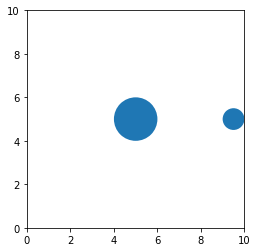

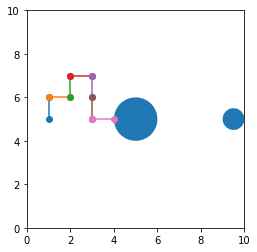

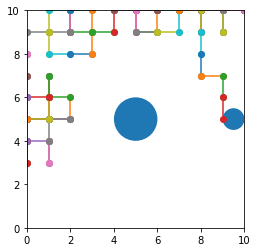

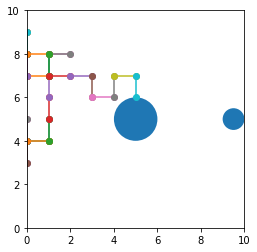

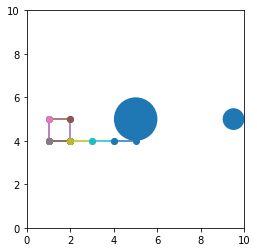

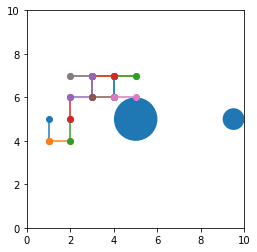

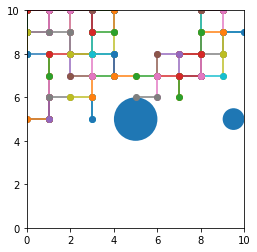

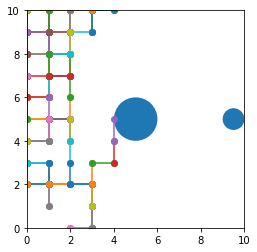

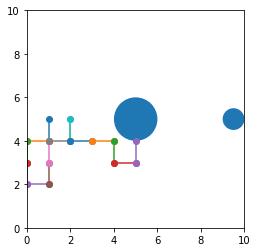

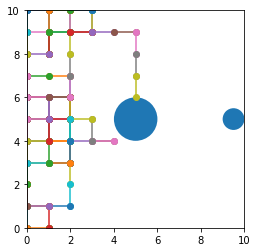

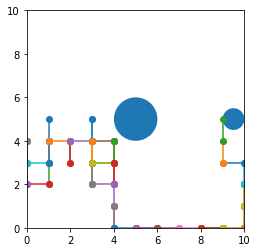

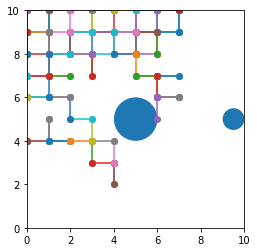

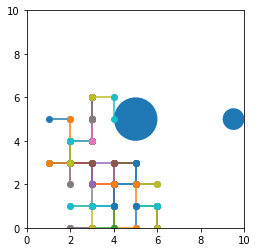

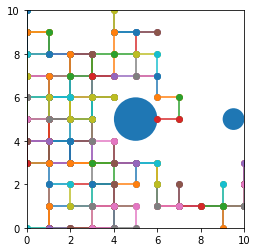

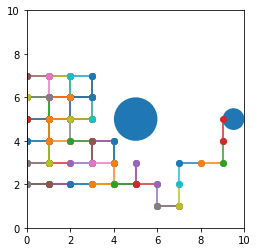

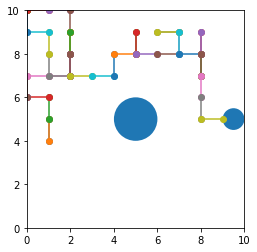

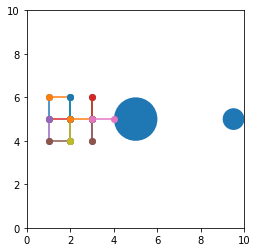

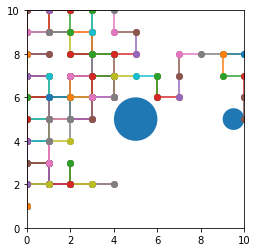

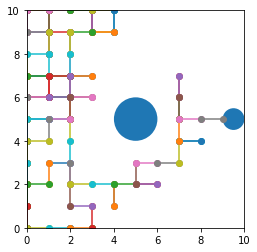

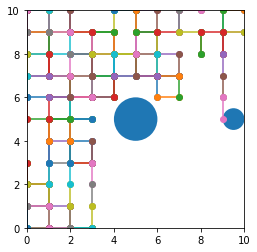

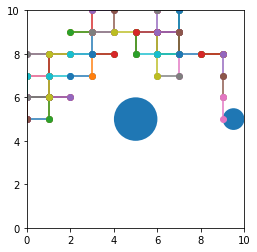

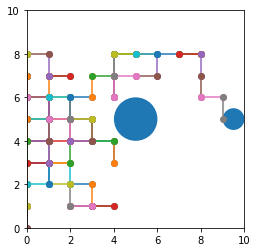

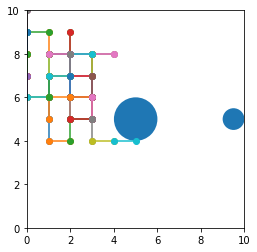

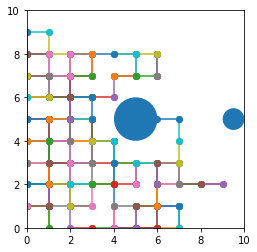

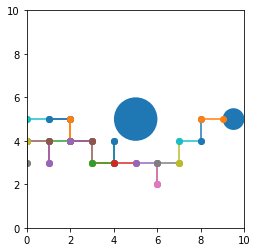

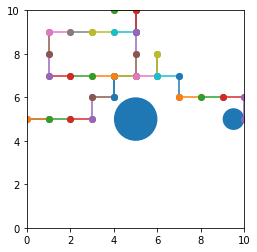

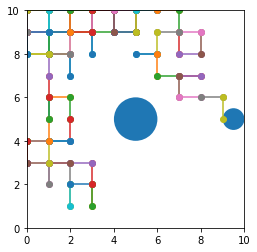

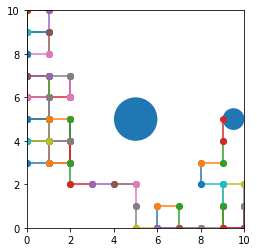

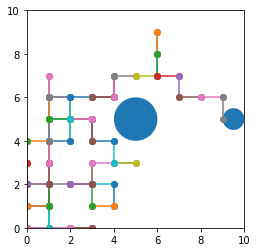

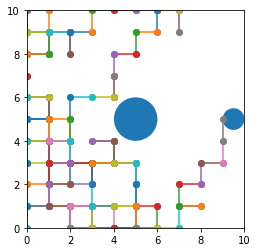

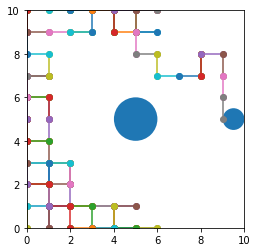

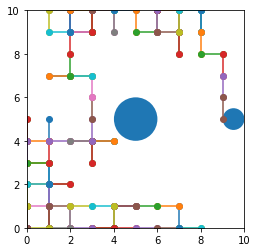

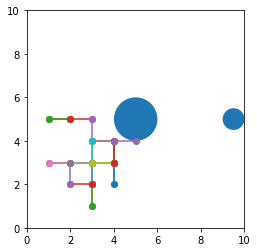

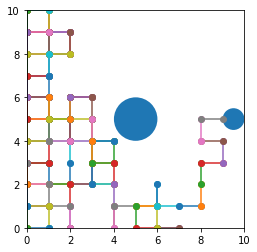

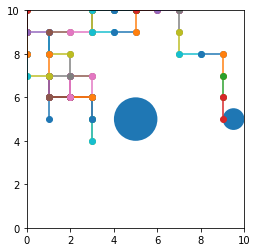

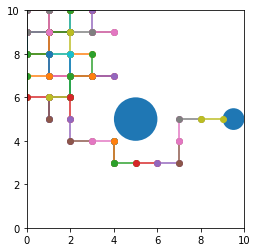

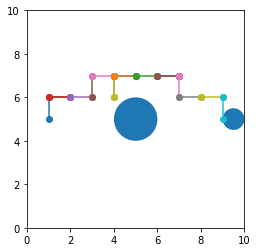

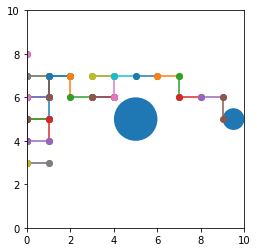

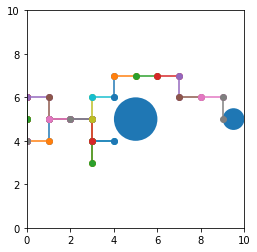

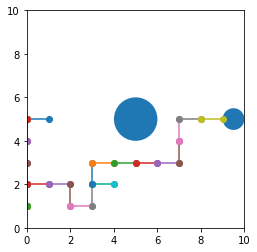

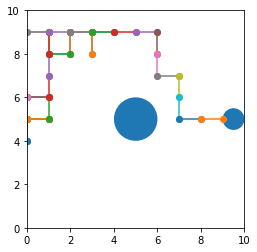

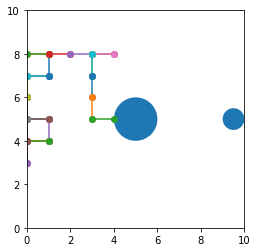

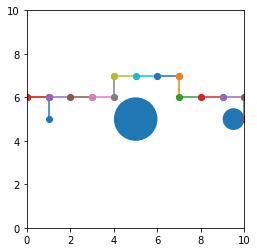

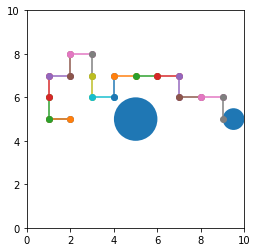

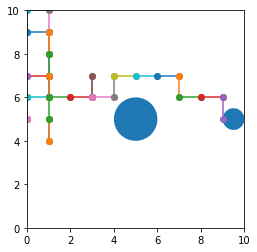

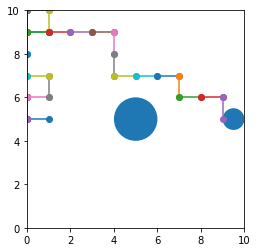

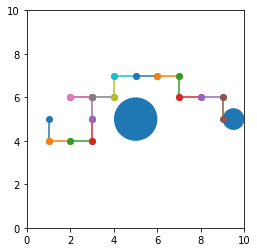

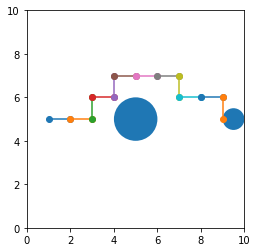

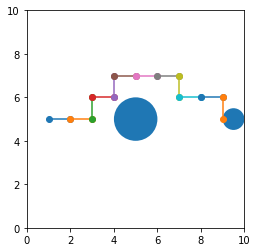

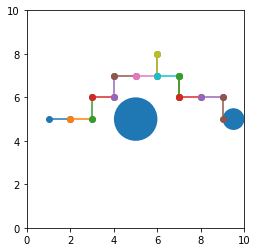

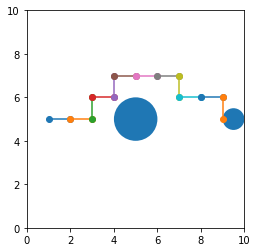

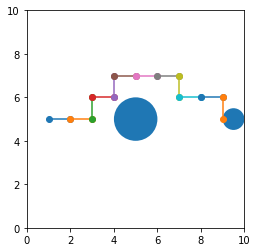

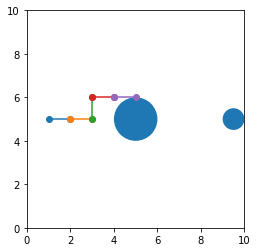

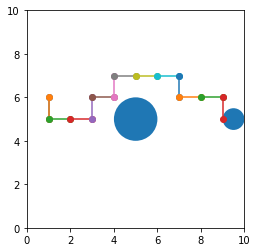

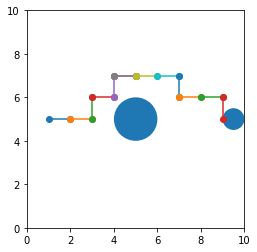

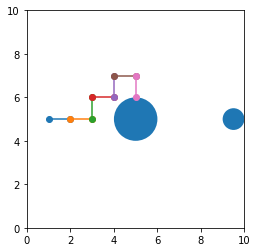

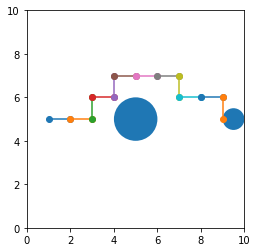

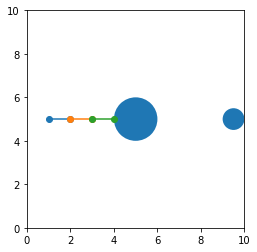

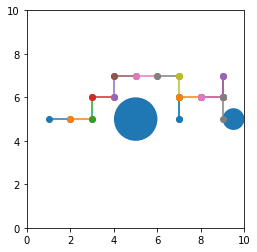

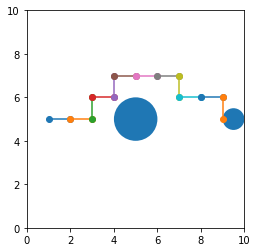

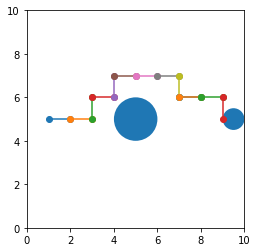

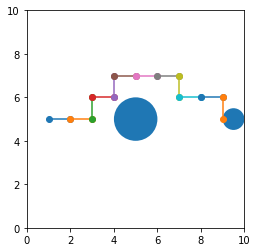

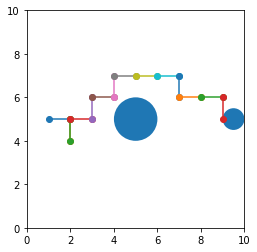

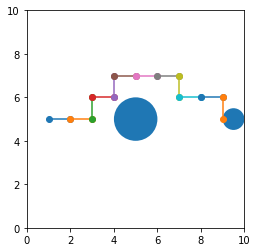

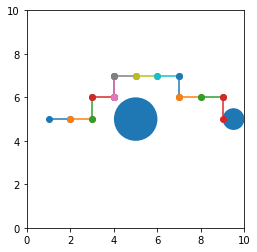

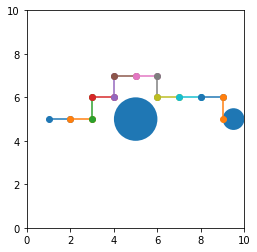

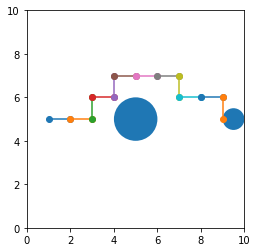

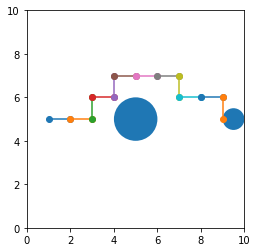

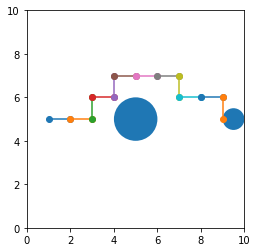

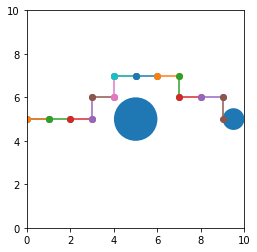

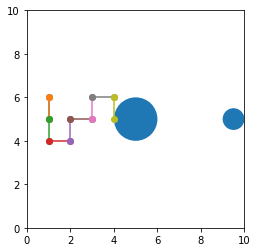

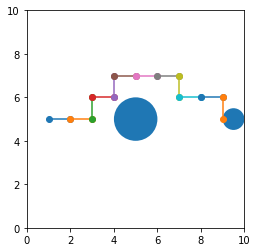

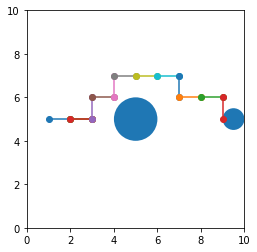

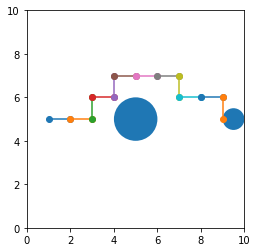

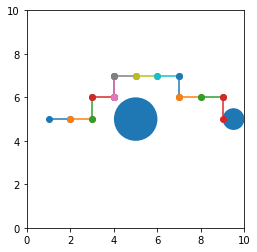

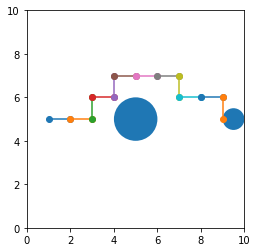

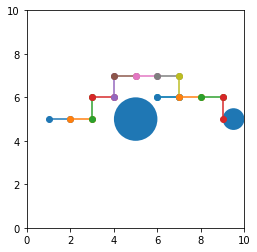

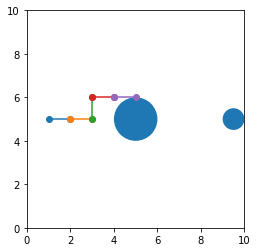

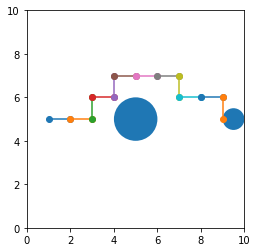

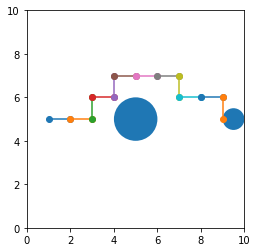

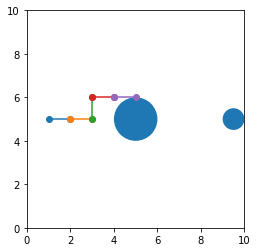

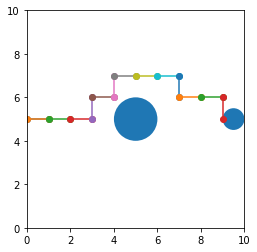

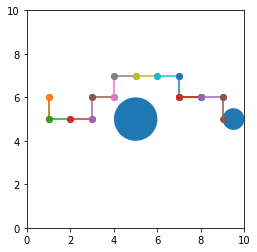

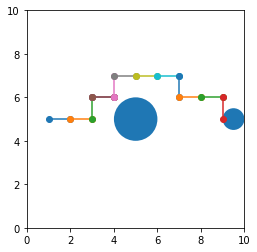

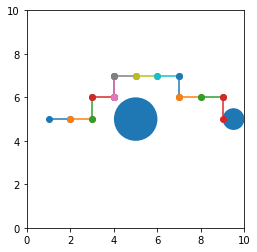

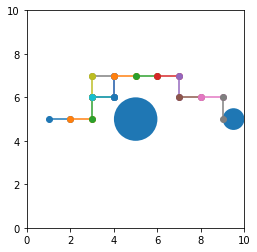

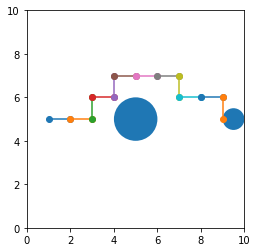

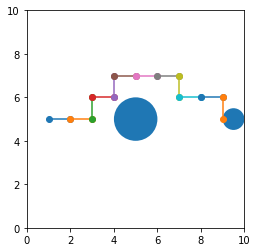

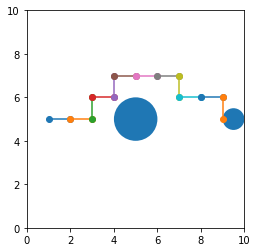

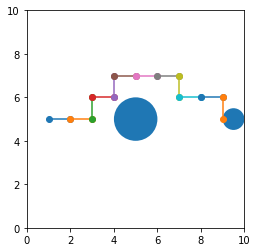

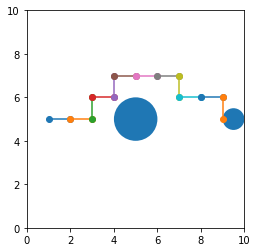

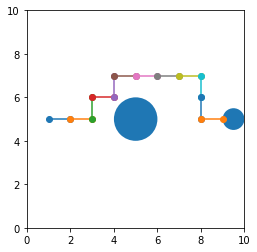

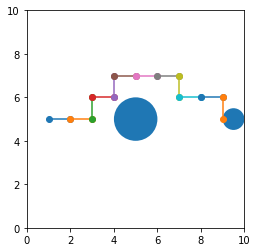

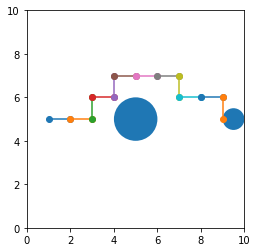

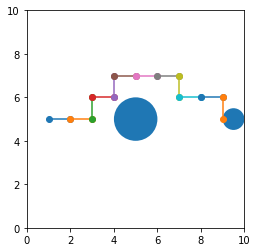

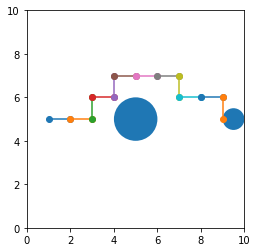

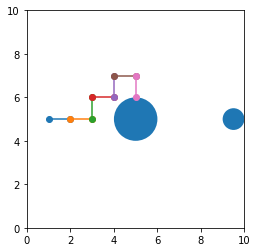

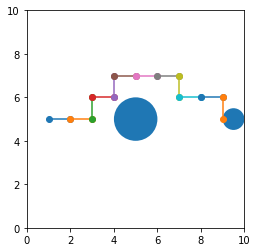

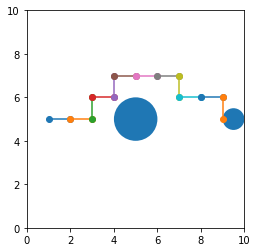

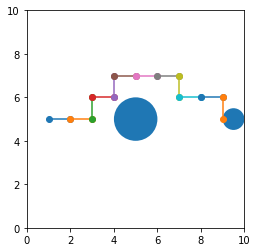

The shortest route: 12
The longest route: 337


In [7]:
def update(env):
    steps = []
    all_costs = []

    for episode in range(100):
        observation = env.reset()

        i = 0

        cost = 0

        while True:
            action = RL.choose_action(str(observation))
            observation_, reward, done = env.step(action)
            cost += RL.learn(str(observation), action, reward, str(observation_))
            observation = observation_
            i += 1
            if done:
                steps += [i]
                all_costs += [cost]
                # positions = env.get_list_of_positions()
                # print(positions)
                break


if __name__ == "__main__":
    env = Environment()
    RL = QLearningTable(actions=list(range(env.n_actions)))
    update(env) 
    env.final()